In [1]:
# !curl https://docs.google.com/uc?id=0B3X9GlR6EmbnWksyTEtCM0VfaFE&export=download

In [2]:
# !curl https://docs.google.com/uc?id=0B3X9GlR6EmbnWksyTEtCM0VfaFE&export=download
# !chmod +x gdrive
# !sudo install gdrive /usr/local/bin/gdrive

chmod: cannot access 'gdrive': No such file or directory
install: cannot stat 'gdrive': No such file or directory


In [3]:
# !gdrive download 1qOpnokPbRh6y0nCQya9El8lySMPBXauq

In [4]:
# !git clone https://github.com/alexgkendall/SegNet-Tutorial.git

In [5]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [6]:
from fastai.callbacks import SaveModelCallback

In [7]:
from fastai import *
from fastai.vision import *
from fastai.callbacks.hooks import *

In [8]:
path = Path('/home/jupyter/data')

In [9]:
path.ls()

[PosixPath('/home/jupyter/data/kansas_2016.zip'),
 PosixPath('/home/jupyter/data/kansas_wheat_square.csv'),
 PosixPath('/home/jupyter/data/kansas_masks_2016'),
 PosixPath('/home/jupyter/data/0kb_tiles.txt'),
 PosixPath('/home/jupyter/data/models'),
 PosixPath('/home/jupyter/data/crop_masks.csv'),
 PosixPath('/home/jupyter/data/0kb_masks.txt'),
 PosixPath('/home/jupyter/data/kansas_wheat_sq_2016')]

In [10]:
fnames = get_image_files(path/'kansas_wheat_sq_2016')
fnames[:3]

[PosixPath('/home/jupyter/data/kansas_wheat_sq_2016/mask_tile_15900_1500.tif'),
 PosixPath('/home/jupyter/data/kansas_wheat_sq_2016/mask_tile_10200_10200.tif'),
 PosixPath('/home/jupyter/data/kansas_wheat_sq_2016/mask_tile_5700_900.tif')]

In [11]:
lbl_names = get_image_files(path/'kansas_masks_2016')
lbl_names[:3]

[PosixPath('/home/jupyter/data/kansas_masks_2016/tile_18900_9600.tif'),
 PosixPath('/home/jupyter/data/kansas_masks_2016/tile_11400_10500.tif'),
 PosixPath('/home/jupyter/data/kansas_masks_2016/tile_7200_7200.tif')]

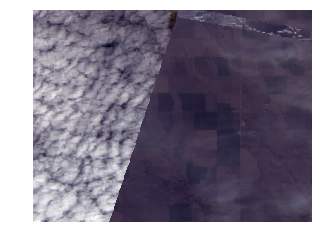

In [12]:
img_f = fnames[2]
img = open_image(img_f)
img.show(figsize=(5,5))

In [13]:
def get_y_fn(x): 
    return Path(str(x.parent.parent)+'/kansas_masks_2016')/x.name[5:]

codes = array(['Sky', 'Building', 'Pole', 'Road', 'Sidewalk', 'Tree',
    'Sign', 'Fence', 'Car', 'Pedestrian', 'Cyclist', 'Void'])

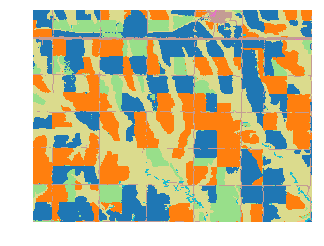

In [14]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

In [15]:
src_size = np.array(mask.shape[1:])
src_size, mask.data

(array([ 934, 1233]), tensor([[[  1,   1,   1,  ...,  24,  24, 121],
          [  1,   1,   1,  ...,  24,  24, 121],
          [  1,   1,   1,  ...,  24,  24, 121],
          ...,
          [121, 121, 121,  ...,   1, 176, 176],
          [ 61,  61,  61,  ...,   1,   1,   1],
          [ 61,  61,  61,  ...,   1,   1,   1]]]))

In [16]:
mask.data.shape

torch.Size([1, 934, 1233])

In [17]:
bs,size = 8, (256,256)

In [18]:
crop_codes = ['void','wheat']

In [19]:
class WheatSegmentationLabelList(SegmentationLabelList):
    def __init__(self, items:Iterator,**kwargs):
        super().__init__(items, **kwargs)
    def open(self, fn): 
        mask = open_mask(fn)
        #corresponds to wheat
        mask.px = (mask.px == 24).float()
#         import pdb; pdb.set_trace()
        return mask

In [20]:
SegmentationItemList._label_cls = WheatSegmentationLabelList

In [21]:
src = (SegmentationItemList.from_folder(path,include='kansas_wheat_sq_2016',extensions='.tif')
       .split_by_rand_pct(0.15)
       .label_from_func(get_y_fn, classes=crop_codes)
      )


In [22]:
warnings.filterwarnings("ignore")

In [23]:
data = (src.transform(get_transforms(flip_vert=True), tfm_y=True, size=size)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

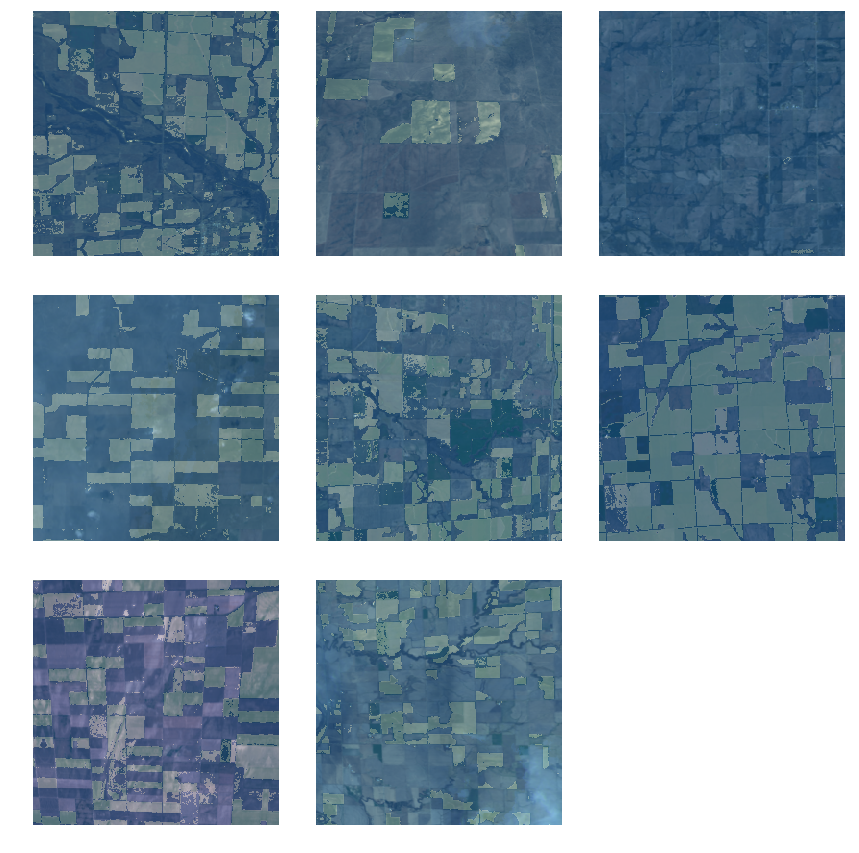

In [24]:
data.show_batch()

In [25]:
def show_single_img_tfms(learn, rows=3, cols=3, figsize=(15, 15)):
    img = learn.data.train_ds.x
    tfms = learn.data.train_ds.tfms
    rand_int = np.random.randint(len(img))
    [img[rand_int].apply_tfms(tfms).show(ax=ax) for i, ax in enumerate(
            plt.subplots(rows, cols, figsize=figsize)[1].flatten())]
    plt.show()
    return learn


Learner.show_single_img_tfms = show_single_img_tfms

In [26]:
crop_codes

['void', 'wheat']

In [27]:
name2id = {v:k for k,v in enumerate(crop_codes)}
void_code = name2id['void']

def acc_crops(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [28]:
metrics=acc_crops
wd=1e-2

In [29]:
# learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd, bottle=True)

# learn.show_single_img_tfms();

# lr_find(learn)
# learn.recorder.plot()

# lr=5e-4

# learn.fit_one_cycle(10, slice(lr), pct_start=0.8)

# learn.save('wheat-vert-2016-big-1')

# learn.unfreeze()
# lrs = slice(lr/100,lr)
# learn.fit_one_cycle(12, lrs, pct_start=0.8)

# learn.save('wheat-vert-2016-big-2')

In [30]:
learn=None
gc.collect()


20921

In [31]:
# the plan was to give 
size = (900,900)
bs=1

In [32]:
data = (src.transform(get_transforms(flip_vert=True), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [33]:
# loading weights from model trained on images sized: 500x500
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd, bottle=True).load('big-wheat-vert-tf-2016-2');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


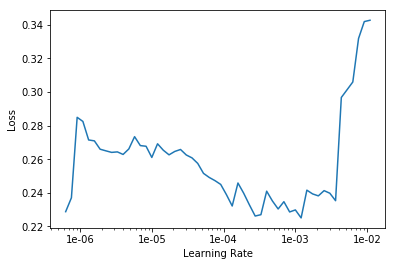

In [34]:
lr_find(learn)
learn.recorder.plot()

In [35]:
lr=1e-3

In [36]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.3)


epoch,train_loss,valid_loss,acc_crops,time
0,0.216540,0.295829,0.459501,31:50
1,0.191574,0.311875,0.421595,31:43
2,0.222243,0.344943,0.467845,31:30
3,0.194797,0.325856,0.457792,31:24
4,0.157017,0.302564,0.357307,31:26
5,0.181517,0.306909,0.367473,31:25


KeyboardInterrupt: 

In [ ]:
learn.save('big-wheat-vert-tf-2016-3')

In [ ]:
# learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd, bottle=True).load('big-wheat-1');


In [ ]:
learn.unfreeze()
lrs = slice(lr/1000,lr/10)
learn.fit_one_cycle(10, lrs, callbacks=[SaveModelCallback(learn,name='big-wheat-vert-2016-2')])

In [ ]:
x,y= next(iter(data.valid_dl))

In [ ]:
plt.imshow(to_np(y[1])[0])

In [ ]:
def overall_acc(input, target):
    target = target.squeeze(1)
    return (input.argmax(dim=1)==target).float().mean()

In [ ]:
learn.validate(metrics=[overall_acc])

In [ ]:
learn.validate()

In [ ]:
y[0].median()

In [ ]:
x,y = data.valid_ds[30]

In [ ]:
a,b,c = learn.predict(x)

In [ ]:
y

In [ ]:
a

In [ ]:
_,ax =plt.subplots(1,1,figsize=(10,10))
x.show(ax=ax)
ax.imshow(c.argmax(0),alpha=0.5)

In [ ]:
x